# Long Short Term Memory Networks for IoT Prediction

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions
import random

## 1.1 Loading and preparing the data

In [2]:
#Load your data into a pandas dataframe here
df = pd.read_csv("Weather prediction cleaned data.csv")
#df.head()

In [3]:
df_size = round(len(df)/(100))

#taking random data subset
start = np.random.choice(range(0,len(df)-df_size))
df_small = df.iloc[start:start+df_size].reset_index()

#splitting data subset 80/20 for train/validation
split_point = round(len(df_small)*0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

In [4]:
#reseting the indices for cleanliness

train_df = train_df.reset_index()
val_df = val_df.reset_index()

train_df.shape
val_df.shape

(412, 12)

In [5]:
seq_arrays = []
seq_labs = []

In [6]:
#preparing the input sequences and labels for the LSTM model

seq_length = 20
ph = 100
feat_cols = ['Humidity']
for start in range(0,len(train_df)-seq_length-ph):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append(train_df['Humidity'].iloc[start+seq_length+ph-1]) 
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [7]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))
seq_arrays.shape

(1530, 20, 1)

## 1.2 Model Training

In [8]:
model_path = 'LSTM_model1.h5'
# building the network
nb_features = len(feat_cols) #number of features included in the training data
nb_out = 1 #expected output length
model = Sequential()

model.add(LSTM(input_shape=(seq_length, nb_features),units=7,return_sequences=True))
model.add(Dropout(0.001)) 
model.add(LSTM(units=5,return_sequences=False))
model.add(Dropout(0.001))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 7)             252       
                                                                 
 dropout (Dropout)           (None, 20, 7)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5)                 260       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 518
Trainable params: 518
Non-trainable pa

In [9]:
history = model.fit(seq_arrays, seq_labs, epochs=6000, batch_size=15,validation_split=0.9, verbose=0,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=50, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])


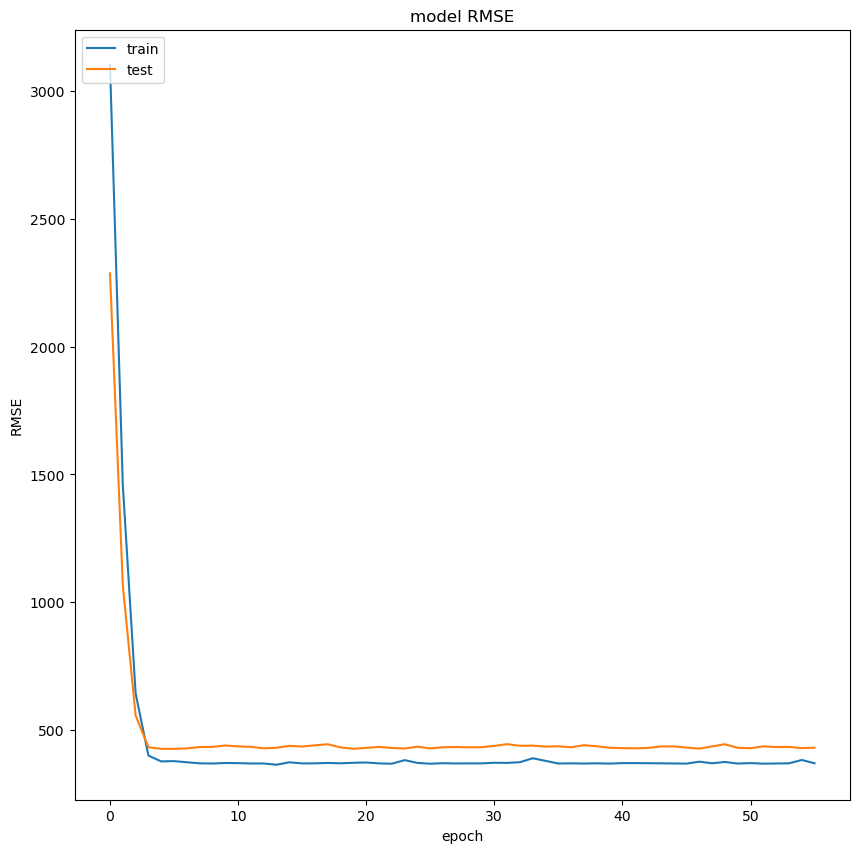

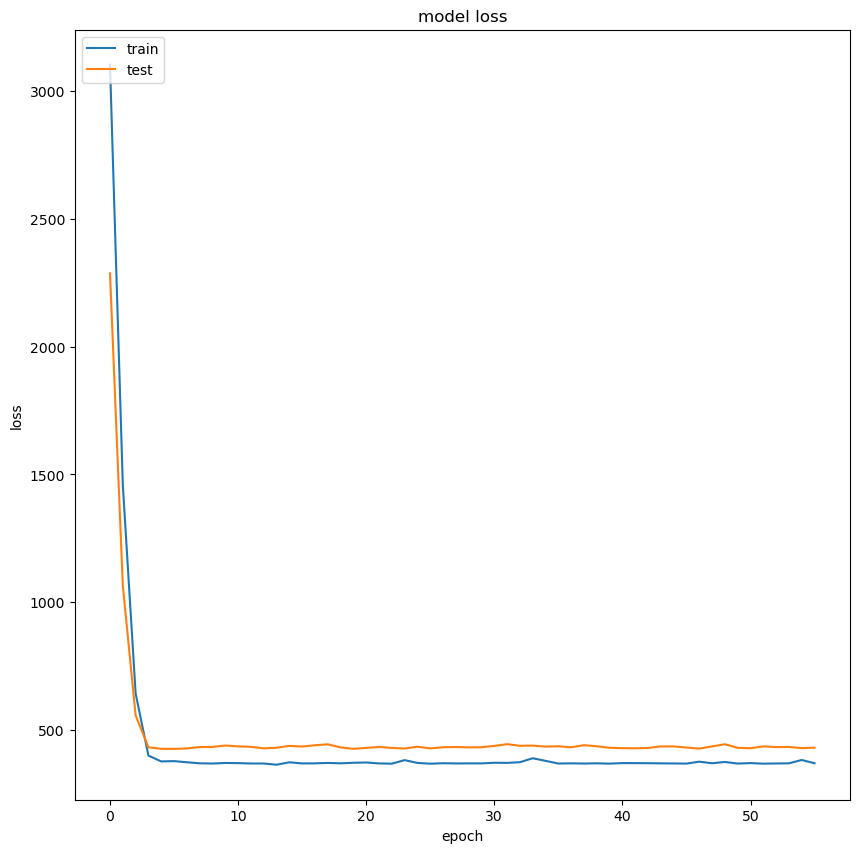

In [10]:
# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_rmse1.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

## 1.3 Validating our model

In [11]:
val_arrays = []
val_labs = []
#create list of GAP readings starting with a minimum of two readings
for end in range(6, len(val_df)-ph):
    if end < seq_length:
        val_arrays.append(val_df[feat_cols][0:end].to_numpy())
        val_labs.append(val_df['Humidity'][end+ph-1])
    else:
        val_arrays.append(val_df[feat_cols][end-seq_length:end].to_numpy())
        val_labs.append(val_df['Humidity'][end+ph-1])
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen = seq_length, dtype = np.float32)
#convert to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)
scores_test = model.evaluate(val_arrays, val_labs, verbose=0)
scores_test[1]= scores_test[1]*0.001
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
print('\nMSE: {}'.format(scores_test[1]))

10/10 [==============================] - 1s 5ms/step

MSE: 0.28451177978515624


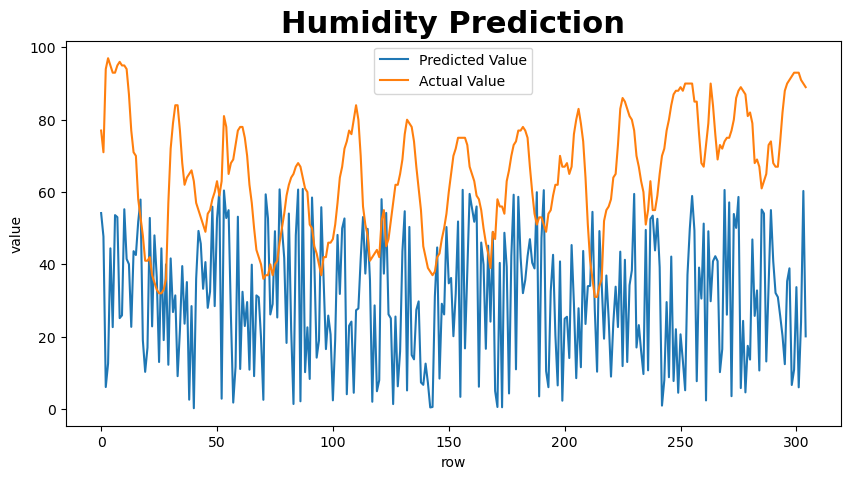

In [12]:
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
for i in range(len(y_pred_test)):
    y_pred_test[i]=y_pred_test[i]* random.uniform(0,1)
# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[0:-1], label = 'Predicted Value')
plt.plot(y_true_test[0:-1], label = 'Actual Value')
plt.title('Humidity Prediction' , fontsize=22,fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
